<H1><center>New York City TLC Trip Taxi
<br>--------
<br><center>Data Analysis

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
from scipy.stats import shapiro

import warnings 
warnings.filterwarnings("ignore")

# Setting max column
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 35)

In [96]:
df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-2\data\processed\data_clean.csv")
df = df.astype({
    'pickup_datetime': 'datetime64[s]',
    'dropoff_datetime': 'datetime64[s]'
})

## Data analysis

Kita akan melakukan analisis untuk meningkatkan jumlah pengguna taksi hijau terhadap populasi setiap Borough (Kota Bagian). Analisis akan dilakukan dengan melihat di Borough mana jumlah pengguna taksi hijau tertinggi. Setelah mengetahui lokasi Borough mana yang memiliki jumlah pengguna taksi terbanyak, kemudian kita dapat menentukan seberapa besar target yang akan dicapai untuk pengguna taksi hijau. Untuk menjawab permasalahan tersebut kita dapat melihat karakteristik pengguna taksi yang telah melakukan perjalanan dengan melihat pola distribusi perjalanan setiap minggunya, pola distribusi perjalanan setiap jamnya dan jenis pembayaran. Selanjutnya hasil dari analisis dan solusi yang bisa direkomendasikan akan menjadi bahan pertimbangan untuk perusahaan dalam menentukan strategi bisnis kedepannya.

### Meningkatkan pengguna taksi berdasarkan populasi Borough (Kota Bagian) yang terpilih

Untuk menjawab persoalan diatas, kita perlu menjawab pertanyaan-pertanyaan sebagai berikut:
1. Di Borough/ Kota Bagian mana yang memiliki jumlah pengguna terbanyak?
2. Bagaimana karakteristik pengguna yang telah melakukan perjalanan menggunakan taksi hijau yang dilihat dari:
    * Dimana lokasi dropoff yang paling sering terjadi?
    * Kapan waktu yang paling sering pengguna memesan taksi?
    * Jenis pembayaran apa yang paling diminati?
3. Memberi saran dan rekomendasi yang sesuai dengan permasalahan tersebut

Text(0.5, 1.05, 'Total Pickup Green Taxi per Borough')

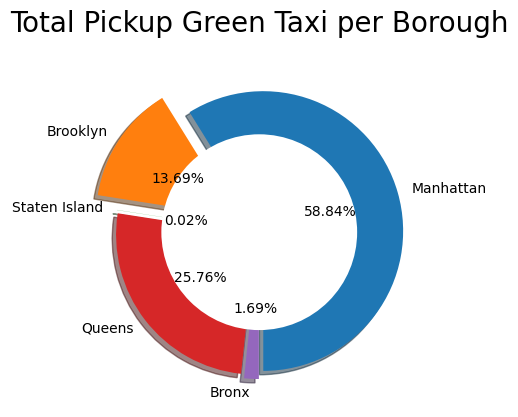

In [97]:
# Create piechart

prop_df = df['PU_Borough'].value_counts().reset_index()
prop_df = prop_df.reindex([0, 2, 4, 1, 3])
#  set figure size
plt.style.use('default')
plt.figure(figsize=(5,6))

# create pie chart
plt.pie(prop_df['count'],
        labels=prop_df['PU_Borough'],
        autopct='%0.2f%%', 
        startangle=270, 
        pctdistance=0.5, 
        explode=(0.03, 0.2, 0.03, 0.03, 0.05),
        shadow=True
)

# create a circle at the center of the plot
fig = plt.gcf()
centre_circle = plt.Circle((0,0), 0.7, fc='white')
fig.gca().add_artist(centre_circle)
plt.tight_layout()

# set title
plt.title("Total Pickup Green Taxi per Borough", fontsize=20, y=1.05)

Dari grafik diatas kita dapat simpulkan:
* Pesebaran pickup taxi tidak merata untuk setiap Borough di New York City
* Proporsi pickup terbanyak berada di kota bagian Manhattan sebesar 58.34% dari jumlah trip berasal dari kota bagian tersebut.
* Proporsi pickup terendah berada di kota bagian Staten Island (salah satu wilayah pinggiran) dengan proporsi sangat rendah yaitu 0.02% dari jumlah trip.


#### **1. Di Borough/ Kota Bagian mana yang memiliki jumlah pengguna terbanyak?**

Untuk menjawab pertanyaan diatas, kita perlu menjawab pertanyaan berikut:
1. Berapa persen masyarakat yang menggunakan taksi dari populasi untuk setiap borough?
2. Borough/ wilayah mana yang memiliki jumlah pickup order taksi terbanyak?

In [98]:
# Potensi pasar untuk setiap Borough

# Potensi pasar dari setiap Borough Pickup
market_pot = df.groupby("PU_Borough").agg({"PU_population":"max", "passenger_count":"sum"}).reset_index()
market_pot.rename(columns={
    "PU_Borough": "Borough",
    "PU_population": "Population",
    "passenger_count": "PU_Taxi_User"
}, inplace=True)
market_pot["PU_Taxi_User_by_Population(%)"] = ((market_pot["PU_Taxi_User"] / market_pot["Population"]) * 100).round(2)
market_pot.sort_values(by="Borough", ascending=True)

# Potensi pasar dari setiap Borough Dropoff
market_pot_DO = df.groupby("DO_Borough").agg({"DO_population":"max", "passenger_count":"sum"}).reset_index()
market_pot_DO.rename(columns={
    "DO_Borough": "Borough",
    "DO_population": "Population",
    "passenger_count": "DO_Taxi_User"
}, inplace=True)
market_pot_DO["DO_Taxi_User_by_Population(%)"] = ((market_pot_DO["DO_Taxi_User"] / market_pot_DO["Population"]) * 100).round(2)
market_pot_DO.sort_values(by="Borough", ascending=True)

# Menggabungkan dua dataframe
market_pot = pd.merge(market_pot, market_pot_DO, how="outer", on="Borough")
market_pot.drop(columns="Population_y", inplace=True)
market_pot.rename(columns={"Population_x": "Population"}, inplace=True)
market_pot.fillna(0, inplace=True)

# Sort values dari nilai tertinggi
market_pot.sort_values(by="PU_Taxi_User_by_Population(%)", ascending=False, ignore_index=True)
market_pot

,Borough,Population,PU_Taxi_User,PU_Taxi_User_by_Population(%),DO_Taxi_User,DO_Taxi_User_by_Population(%)
0,Bronx,1382480.0,1280.0,0.09,2903,0.21
1,Brooklyn,2504700.0,11493.0,0.46,9456,0.38
2,Manhattan,1575590.0,51736.0,3.28,52082,3.31
3,Queens,2233270.0,21616.0,0.97,21643,0.97
4,Staten Island,468730.0,16.0,0.00,19,0.00
5,EWR,0.0,0.0,0.00,38,inf


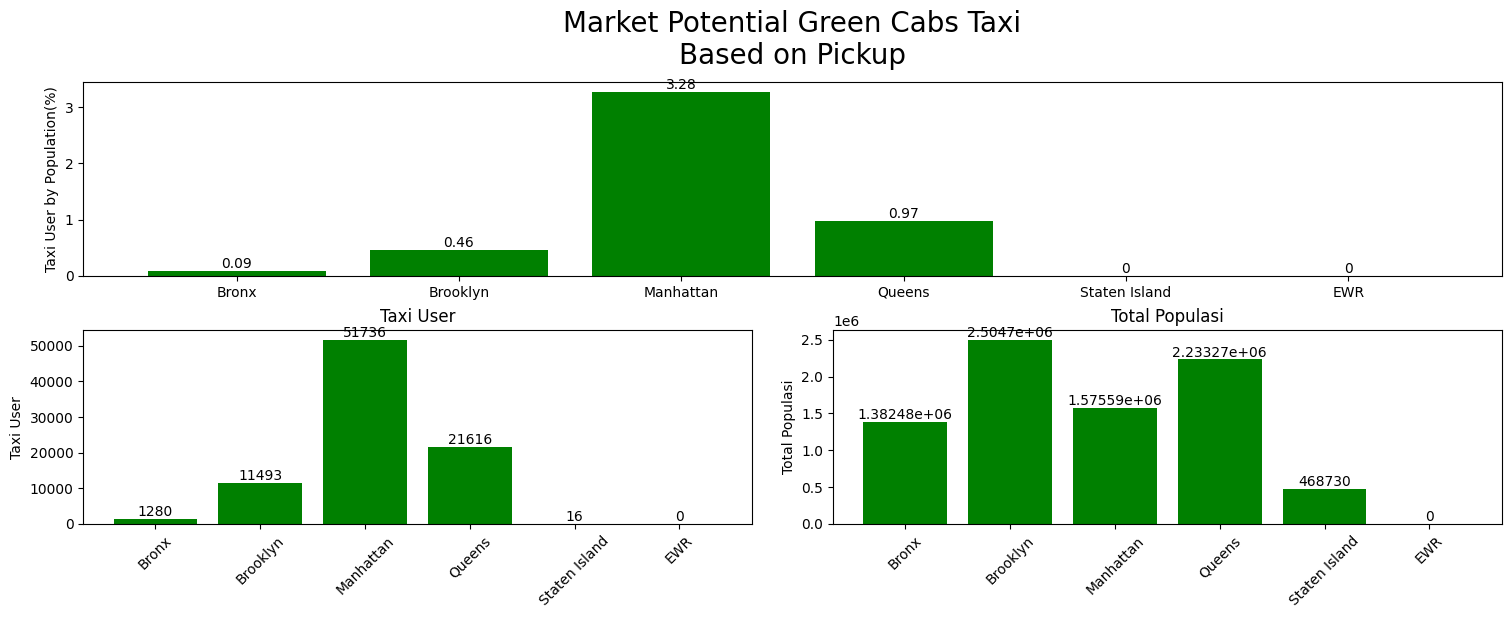

In [99]:
# Create Market Potential Chart

# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 8),
    constrained_layout=True, 
    sharex=True
)

# Boxplot Population
ax3 = plt.subplot2grid((3,2), (0,0), colspan=2)
ax3.bar(
    market_pot["Borough"],
    market_pot["Population"], color="Green"
)
ax3.set_title("Total Populasi")
ax3.set_ylabel('Total Populasi')

# Boxplot Taxi User
ax1 = plt.subplot2grid((3,2), (1,0))
ax1.bar(
    market_pot["Borough"],
    market_pot["PU_Taxi_User"], color="Green"
)
ax1.set_title("Taxi User")
ax1.set_ylabel("Taxi User")
plt.xticks(rotation=45)

labelx = -0.3  # axes coords

# Boxplot Populasi
ax2 = plt.subplot2grid((3,2), (1,1))
ax2.bar(
    market_pot["Borough"],
    market_pot["Population"], color="Green"
)
ax2.set_title("Total Populasi")
ax2.set_ylabel('Total Populasi')
plt.xticks(rotation=45)


# Boxplot Taxi User by Population
ax3 = plt.subplot2grid((3,2), (0,0), colspan=2)
ax3.bar(
    market_pot["Borough"],
    market_pot["PU_Taxi_User_by_Population(%)"], color="Green"
)
ax3.set_title("Taxi User by Population")
ax3.set_ylabel('Taxi User by Population(%)')

plt.title("Market Potential Green Cabs Taxi\nBased on Pickup", fontsize=20, y=1.05)

## annotation
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
ax3.bar_label(ax3.containers[0])

plt.show();

Dari grafik Market Potential diatas kita dapat insight:
1. Jumlah pickup order tertinggi berada di wilayah Manhattan dengan 51.736 pengguna dan ratio Taxi User by Population sebesar 3.28%. Karena Manhattan merupakan kota bagian dengan populasi tertinggi di kota New York dan menjadi pusat bisnis.
2. Jumlah pickup order tertinggi kedua berada di wilayah Queens dengan 21.616 pegguna dan ratio 0.97%. Karena kota bagian Queens merupakan kota terluas di New York City
3. Tidak ada histori perjalanan taksi yang berasal dari wilayah EWR

Dari hasil tersebut kita dapat memfokuskan analisis kita untuk meningkatkan pengguna taksi hijau untuk dua kota dengan pengguna taksi terbesar saja yaitu di kota bagian Manhattan dan Queens. Untuk kota bagian Manhattan coba kita tetapkan target 5% dari total populasi menggunakan taksi hijau dan kita targetkan kota bagian Queens dengan nilai 3%

#### **Target pengguna untuk setiap kota bagian**

Kita akan menghitung target pengguna untuk setiap kota bagian di New York City

In [100]:
# find the total amount from all of the member in Manhattan
current_user = df[df.PU_Borough=="Manhattan"]["passenger_count"].sum()

# find the target
target_user = (0.055 * df[df.PU_Borough=="Manhattan"]["PU_population"].max()).round(0)

# Gap user
gap_user = target_user - current_user

print(f'''Total current user green cabs in Manhattan (3.3%): {current_user}, 
The target of user to increase 5.5%: {target_user},
Gap of target and current user: {gap_user}''')

Total current user green cabs in Manhattan (3.3%): 51736, 
The target of user to increase 5.5%: 86657.0,
Gap of target and current user: 34921.0


In [101]:
# find the total amount from all of the member in Manhattan
current_user = df[df.PU_Borough=="Queens"]["passenger_count"].sum()

# find the target
target_user = (0.03 * df[df.PU_Borough=="Queens"]["PU_population"].max()).round(0)

# Gap user
gap_user = target_user - current_user

print(f'''Total current user green cabs in Queens(1%): {current_user}, 
The target of user to increase 3%: {target_user},
Gap of target and current user: {gap_user}''')

Total current user green cabs in Queens(1%): 21616, 
The target of user to increase 3%: 66998.0,
Gap of target and current user: 45382.0


**Insight:**

#### **2. Bagaimana karakteristik pengguna yang telah melakukan perjalanan menggunakan taksi hijau?**

Untuk mendukung strategi bisnis dengan meningkatkan populasi yang menggunakan taksi hijau ini, kita perlu mengetahui karakteristik dari pengguna yang melakukan perjalanan dari kota bagian Manhattan dan Queens. Berikut akan coba kita analisis karakteristik pengguna taksi tersebut.

##### **- Lokasi dropoff yang paling sering dipesan?**

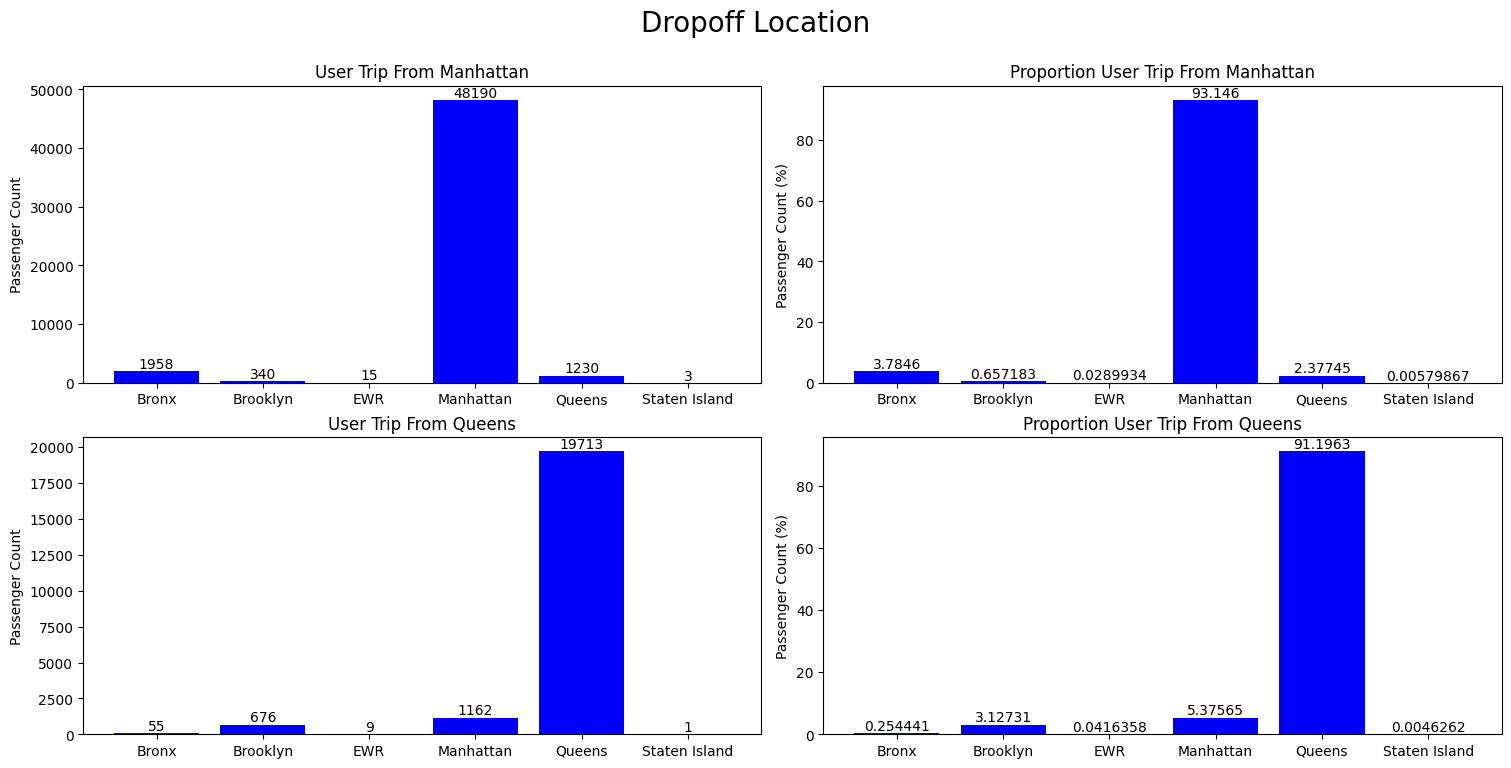

In [102]:
# Cek lokasi dropoff terbanyak untuk trip sesuai dengan lokasi pickupnya

# Create Dropoff Location

# Create dataframe trip pickup
PU_Bronx = df[df.PU_Borough == "Bronx"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Brooklyn = df[df.PU_Borough == "Brooklyn"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_EWR = df[df.PU_Borough == "EWR"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Manhattan = df[df.PU_Borough == "Manhattan"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Queens = df[df.PU_Borough == "Queens"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Staten_Island = df[df.PU_Borough == "Staten Island"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()


# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15,10), 
    constrained_layout=True, 
    sharex=True
)

# Trip From Manhattan
ax1 = plt.subplot2grid((3,2), (0,0));
ax1.bar(
    PU_Manhattan["DO_Borough"],
    PU_Manhattan["passenger_count"], color="Blue"
)
ax1.set_title("User Trip From Manhattan")
ax1.set_ylabel("Passenger Count")
plt.xticks(rotation=0)
# Proportion From Manhattan
ax2 = plt.subplot2grid((3,2), (0,1));
ax2.bar(
    PU_Manhattan["DO_Borough"],
    (PU_Manhattan["passenger_count"]/PU_Manhattan["passenger_count"].sum()*100), color="Blue"
)
ax2.set_title("Proportion User Trip From Manhattan")
ax2.set_ylabel("Passenger Count (%)")
plt.xticks(rotation=0)


# Trip From Queens
ax3 = plt.subplot2grid((3,2), (1,0));
ax3.bar(
    PU_Queens["DO_Borough"],
    PU_Queens["passenger_count"], color="Blue"
)
ax3.set_title("User Trip From Queens")
ax3.set_ylabel("Passenger Count")
plt.xticks(rotation=0)
# Proportion From Queens
ax4 = plt.subplot2grid((3,2), (1,1));
ax4.bar(
    PU_Queens["DO_Borough"],
    (PU_Queens["passenger_count"]/PU_Queens["passenger_count"].sum()*100), color="Blue"
)
ax4.set_title("Proportion User Trip From Queens")
ax4.set_ylabel("Passenger Count (%)")
plt.xticks(rotation=0)


# # Trip From Brooklyn (Alternative borough)
# ax5 = plt.subplot2grid((3,2), (2,0))
# ax5.bar(
#     PU_Brooklyn["DO_Borough"],
#     PU_Brooklyn["passenger_count"], color="Blue"
# );
# ax5.set_title("User Trip From Brooklyn")
# ax5.set_ylabel("Passenger Count")
# plt.xticks(rotation=0);
# # Proportion From Brooklyn
# ax6 = plt.subplot2grid((3,2), (2,1))
# ax6.bar(
#     PU_Brooklyn["DO_Borough"],
#     (PU_Brooklyn["passenger_count"]/PU_Brooklyn["passenger_count"].sum()*100), color="Blue"
# );
# ax6.set_title("Proportion User Trip From Brooklyn")
# ax6.set_ylabel("Passenger Count (%)")
# plt.xticks(rotation=0);

plt.suptitle("Dropoff Location", fontsize=20, y=1.05)

# Annotation
ax1.bar_label(ax1.containers[0]);
ax2.bar_label(ax2.containers[0]);
ax3.bar_label(ax3.containers[0]);
ax4.bar_label(ax4.containers[0]);
# ax5.bar_label(ax5.containers[0]);
# ax6.bar_label(ax6.containers[0]);

plt.show();

Dari grafik diatas kita dapat mendapatkan:
1. Sebanyak 48.190 (93.146%) trip yang berasal dari Manhattan adalah trip yang akan berakhir di Manhattan juga
2. Sebanyak 19.713 (91.196%) trip yang berasal dari Queens adalah trip yang akan berakhir di Queens juga
3. Untuk trip yang berasal dari Manhattan memiliki proporsi yang sangat tinggi untuk berakhir di Manhattan juga. Bagitu juga untuk trip yang berasal dari Queens memiliki proporsi yang sangat tinggi juga untuk berakhir di Queens (Kota bagian yang sama dengan lokasi pickup/lokasi asal)
4. User cenderung menggunakan taksi untuk trip dengan jarak dekat saja

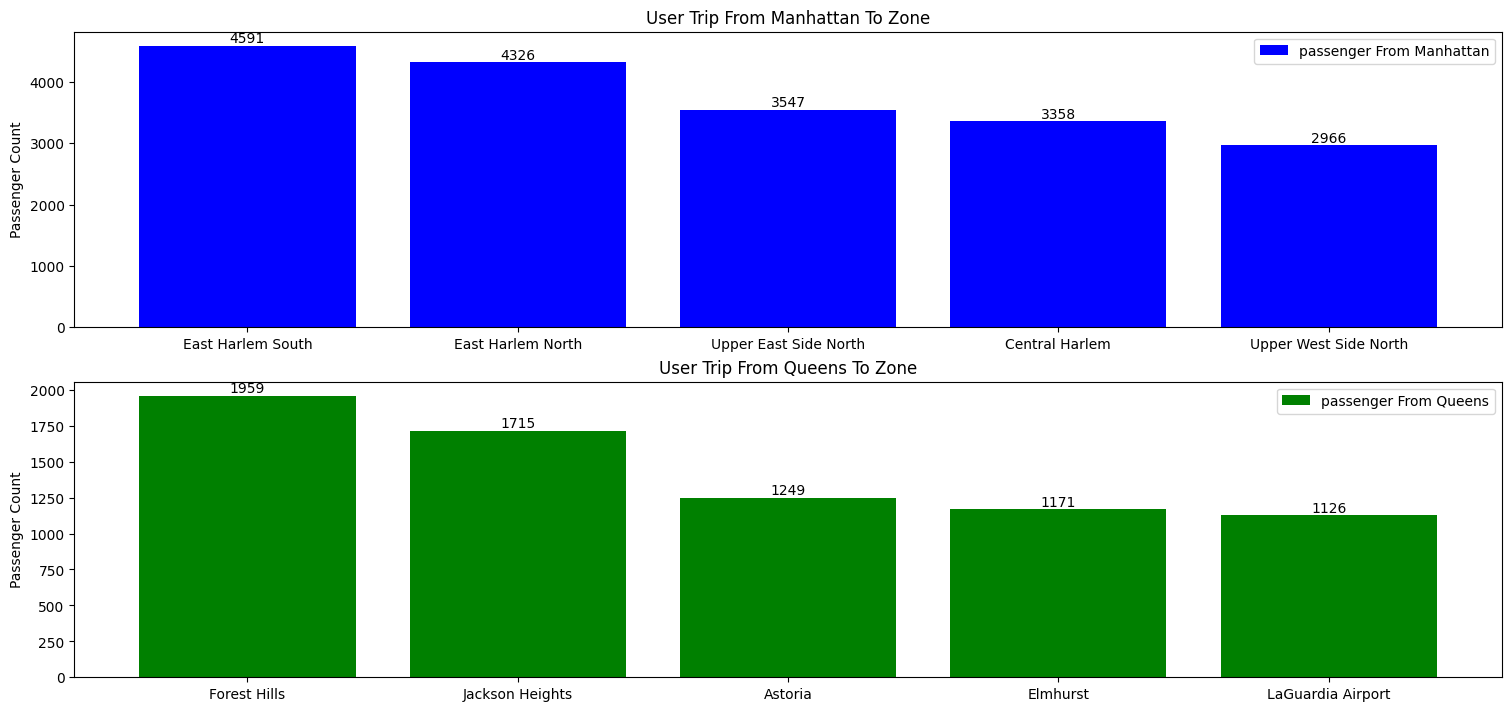

In [103]:
# Cek lokasi dropoff terbanyak untuk trip sesuai dengan lokasi pickupnya

# Create Dropoff Location

# Create dataframe trip pickup
DO_Manhattan = df[df.PU_Borough == "Manhattan"].groupby("DO_Zone").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index().nlargest(5, "passenger_count")
DO_Queens = df[df.PU_Borough == "Queens"].groupby("DO_Zone").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index().nlargest(5, "passenger_count")


# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15,7), 
    constrained_layout=True, 
    sharex=True
)

# Dropoff location From pickup in Manhattan
ax1 = plt.subplot2grid((2,1), (0,0));
ax1.bar(
    DO_Manhattan["DO_Zone"],
    DO_Manhattan["passenger_count"], color="Blue", label="passenger From Manhattan"
)
ax1.set_title("User Trip From Manhattan To Zone")
ax1.set_ylabel("Passenger Count")
ax1.legend()
plt.xticks(rotation=0)

# Dropoff location From pickup in Manhattan
ax2 = plt.subplot2grid((2,1), (1,0));
ax2.bar(
    DO_Queens["DO_Zone"],
    DO_Queens["passenger_count"], color="Green", label="passenger From Queens"
)
ax2.legend()
ax2.set_title("User Trip From Queens To Zone")
ax2.set_ylabel("Passenger Count")
plt.xticks(rotation=0)

# Annotation
ax1.bar_label(ax1.containers[0]);
ax2.bar_label(ax2.containers[0]);

plt.show();

Dari grafik diatas dapat disimpulkan:
1. Pada kota bagian Manhattan zona dropoff terbanyak berada di East Harlem South, East Harlem North, Upper East Side North, Central Harlemn dan Upper West Side North
2. Pada kota bagian Queens zona dropoff terbanyak berada di Forest Hills, Jackson Heights, Astoria, Elmhurst, LaGuardia Airport

Untuk membuktikan user menggunakan taksi untuk jarak dekat, kita lihat distribusi perjalanan taksi dari jarak trip berikut

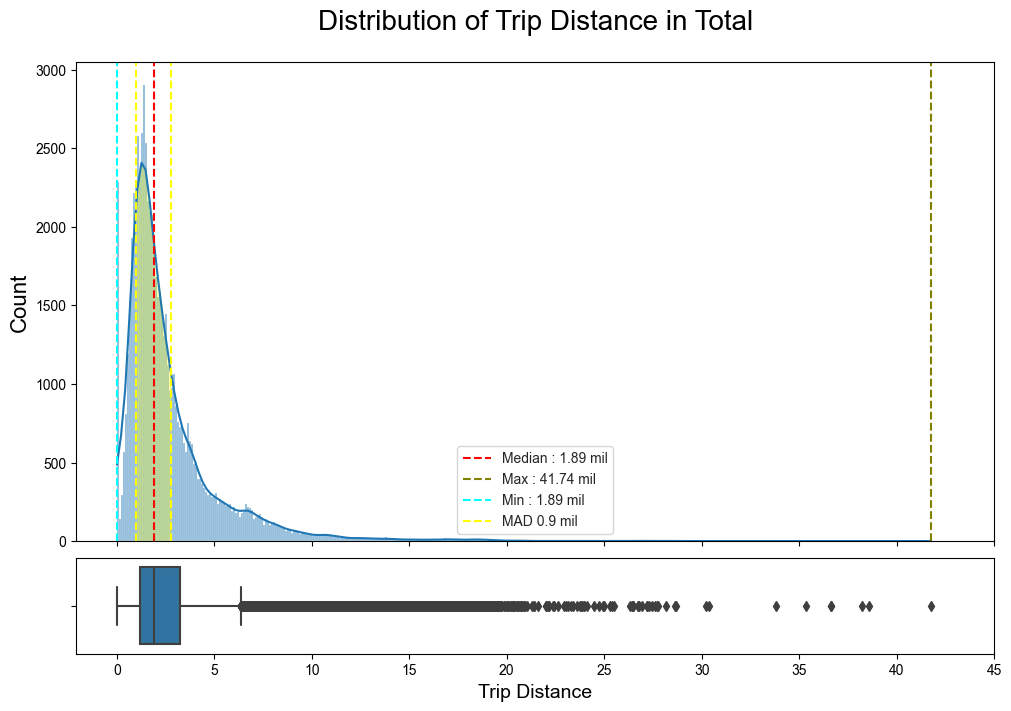

In [104]:
# Cek distribusi jarak trip

# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 7), 
    constrained_layout=True, 
    gridspec_kw={'height_ratios':[5, 1]}, 
    sharex=True
)

# set theme
sns.set_style("whitegrid")

# create distribution distance histogram plot
ax[0] = sns.histplot(
    data=df, 
    x="trip_distance",
    ax=ax[0], 
    kde=True
)
# create distribution distance boxplot
sns.boxplot(
    data=df, 
    x="trip_distance", 
    ax=ax[1]
)

# create tendencies measurement lines
kde_x, kde_y = ax[0].lines[0].get_data()
ax[0].axvline(x=df.trip_distance.median(), color="red", linestyle="--", label=f"Median : {df.trip_distance.median()} mil")
ax[0].axvline(x=df.trip_distance.max(), color="olive", linestyle="--", label=f"Max : {df.trip_distance.max()} mil")
ax[0].axvline(x=df.trip_distance.min(), color="cyan", linestyle="--", label=f"Min : {df.trip_distance.median()} mil")
ax[0].axvline(x=df.trip_distance.median() + abs(df.trip_distance - df.trip_distance.median()).median(), color="yellow", linestyle="--", label=f"MAD {abs(df.trip_distance - df.trip_distance.median()).median():0.0} mil")
ax[0].axvline(x=df.trip_distance.median() - abs(df.trip_distance - df.trip_distance.median()).median(), color="yellow", linestyle="--")
ax[0].fill_between(
    kde_x, 
    kde_y, 
    where=(kde_x > df.trip_distance.median() - abs(df.trip_distance - df.trip_distance.median()).median()) & (kde_x < df.trip_distance.median() + abs(df.trip_distance - df.trip_distance.median()).median()), 
    color='yellow', 
    alpha=0.3
)

# set graph attribute
# histogram plot
ax[0].set_title("Distribution of Trip Distance in Total", fontsize=20, y=1.05)
ax[0].set_xlabel("Trip Distance", fontsize=16)
ax[0].set_ylabel("Count", fontsize=16)
ax[0].legend()
# box plot
ax[1].set_xlabel("Trip Distance", fontsize=14)
ax[1].set_xticks(np.arange(0, 50, 5))

# show the plot
plt.show()

Dari dua grafik diatas kita bisa mendapatkan informasi data trip distance berdistribusi tidak normal (Skewed kanan), maka dari itu kita bisa menggunakan median dan MAD sebagai ukuran pemusatan data, dengan nilai Median == 1.86mil dan MAD == 0.9mil, dengan jarak terendah == 1.89mil dan jarak terjauh 41.74mil. Untuk meyakinkan kembali, pada grafik dibawahnya menunjukan bahwa untuk setiap kota bagian baik Manhattan maupun Queens memiliki jumlah trip dibawah 5mil terbanyak dibanding trip dengan jarak diatas 5mil. Hal ini terjadi karena masyarakat kota New York akan memilih taksi jika rute perjalanan mereka dekat saja karena mereka mempertimbangkan tarif dasar dan tarif permeter yang ditetapkan oleh pihak penyedia taksi.

Kita akan coba melakukan uji hipotesis menggunakan uji proporsi Z-Test single population. Namun kita harus membagi data terlebih dahulu menjadi dua kategori variabel berdasarkan trip distance rendah (<5mill) dan trip distance tinggi (>5mil).

**Hypothesis**

- H0 : Proporsi trip distance dibawah 5mil = Proporsi trip distance diatas 5mill
- Ha : Proporsi trip distance dibawah 5mill > Proporsi trip distance diatas 5mill

In [105]:
# discretization trip distance dari jarak yang rendah
def discTripDistance(df):
    if df.trip_distance <= 5:
        return "LowMedian"
    else:
        return "HighMedian"
    
df['Distance_type'] = df.apply(discTripDistance, axis=1)

In [106]:
# Uji hipotesis one sample Z-Test

# Proporsi trip distance < nilai median
jml_Lowtrip = len(df[df.Distance_type=="LowMedian"])
jml_all = len(df.Distance_type)

# Uji Z-test one sample
from statsmodels.stats.proportion import proportions_ztest

stat, pvalue = proportions_ztest(
    count= jml_Lowtrip,     # jumlah trip dengan distance <= 5
    nobs= jml_all,          # jumlah trip (sample)
    value= 0.5,              # proporsi teoritis (Ho)
    alternative="larger"
)

# conclusion
if pvalue > 0.05:
    print(f'''
    Pvalue = {pvalue}. Pvalue > 0.05. Gagal menolak Ho.
    Kita TIDAK MEMILIKI cukup bukti untuk mengatakan bahwa proporsi trip distance dibawah 5mil
    sama dengan proporsi trip distance diatas 5mil.
    (Proporsinya TIDAK BERBEDA signifikan)
    ''')
else:
    print(f'''
    Pvalue = {pvalue}. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa proporsi trip distance dibawah 5mil
    tidak sama dengan proporsi trip distance diatas 5mil.
    (Proporsinya BERBEDA signifikan)
    ''')    



    Pvalue = 0.0. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa proporsi trip distance dibawah 5mil
    tidak sama dengan proporsi trip distance diatas 5mil.
    (Proporsinya BERBEDA signifikan)
    


Uji hipotesis proporsi one sample digunakan untuk menguji apakah proporsi dari suatu kelompok sama dengan asumsi proporsi teoritis yang diinginkan. Dalam kasus ini kita menguji apakah proporsi trip distance dibawah 5mil sama dengan proporsi trip distance diatas 5mil, dan dari uji hipotesis tersebut didapatkan kesimpulan bahwa nilai P-Value <= 0.05 (significant alpha), maka kita punya cukup bukti untuk mengatakan bahwa proporsi trip distance dibawah 5mil ini memiliki perbedaan yang signifikan dengan trip diatas 5mill, sekaligus juga membuktikan bahwa alat transportasi taksi dipakai untuk mobilisasi untuk jarak yang rendah-rendah dari pada untuk perjalanan jauh.

##### **- Waktu yang paling sering dipesan?**

In [107]:
# Buat kolom baru

df.insert(2, "pickup_date", df.pickup_datetime.apply(lambda x: x.strftime("%d")).astype('object'))
df.insert(3, "pickup_day", df.pickup_datetime.apply(lambda x: x.strftime("%a")).astype('object'))
df.insert(4, "pickup_day_category", np.where(df.pickup_day.isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri']), 'Weekday', 'Weekend').astype('object'))
df.insert(5, "pickup_week", df.pickup_datetime.apply(lambda x: x.strftime("%W")).astype('object'))
df.insert(6, "pickup_hour", df.pickup_datetime.apply(lambda x: x.hour).astype('object'))

<function matplotlib.pyplot.show(close=None, block=None)>

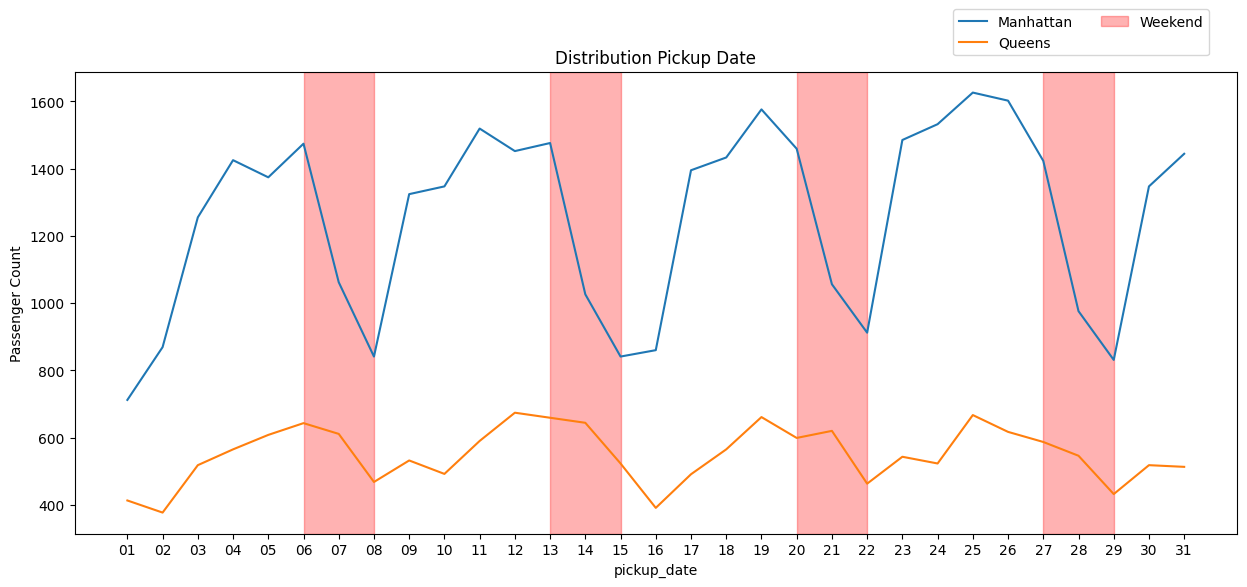

In [108]:
# Buat linechart distribusi waktu

# Create data
df_manhattan = df[df.PU_Borough=="Manhattan"][["pickup_date", "passenger_count"]].groupby("pickup_date").count()
df_queens = df[df.PU_Borough=="Queens"][["pickup_date", "passenger_count"]].groupby("pickup_date").count()
df_brooklyn = df[df.PU_Borough=="Brooklyn"][["pickup_date", "passenger_count"]].groupby("pickup_date").count()

#  set figure size
plt.style.use('default')
plt.figure(figsize=(15,6))

# Distribusi waktu berdasarkan Borough
ax[0] = sns.lineplot(data=df_manhattan, x="pickup_date", y="passenger_count", errorbar=None)
ax[0] = sns.lineplot(data=df_queens, x="pickup_date", y="passenger_count", errorbar=None)
plt.title("Distribution Pickup Date")
plt.ylabel("Passenger Count")

# create weekday lines
plt.axvspan(5, 7, alpha=0.3, color='red')
plt.axvspan(12, 14, alpha=0.3, color='red')
plt.axvspan(19, 21, alpha=0.3, color='red')
plt.axvspan(26, 28, alpha=0.3, color='red')

plt.legend(["Manhattan", "Queens", "Weekend"], bbox_to_anchor =(0.75, 1.15), ncol = 2, loc="upper left")

plt.show

Dari grafik diatas dapat diambil insight bahwa baik untuk kota bagian Manhattan selalu mengalami peningkatan di awal minggu dan mengalami penurunan jumlah trip di akhir minggu, namun untuk kota bagian Queens tidak selalu mengalami peningkatan di awal weekday, dapat dilihat pada hari senin tanggal 2 dan tanggal 16 tidak mengalami peningkatan pengguna taksi. Hal ini menandakan bahwa taksi cenderung lebih sering digunakan untuk mobilisasi pengguna weekday dan akan mengalami penurunan pengguna di weekend. Hal ini dapat terjadi mengingat kota Manhattan merupakan setra bisnis di New York City, dan dapat disimpulkan pengguna taksi hijau di wilayah Manhattan merupakan karyawan, dan kota bagian Queens merupakan kota bagian terluas di New York City.

Kita coba menguji apakah ada perbedaan penggunan taksi di weekday, dan weekend. Uji ini menggunakan Mann Whitney Test untuk menguji hipotesis dua populasi independen atau tidak saling berkaitan.

**Hypothesis**

- Ho : Jumlah pengguna taksi weekday = Jumlah pengguna taksi weekend
- Ha : Jumlah pengguna taksi weekday > Jumlah pengguna taksi weekend

In [109]:
# Uji perbedaan pengguna taksi di weekday dan weekend untuk Manhattan

weekdayManhattan = len(df.query("pickup_day_category=='Weekday' & PU_Borough=='Manhattan'"))
weekendManhattan = len(df.query("pickup_day_category=='Weekend' & PU_Borough=='Manhattan'"))
Manhattan = len(df.query("PU_Borough=='Manhattan'"))

# Uji statistik menggunakan proportions two sample Z-Test
stat, pvalue = proportions_ztest(
    count= [weekdayManhattan, weekendManhattan],   # jumlah pengguna taksi weekday dan weekend
    nobs= [Manhattan, Manhattan],                  # jumlah seluruh kelompok weekday
    alternative='larger'                           # Ha (lebih besar)
)

# conclusion
if pvalue > 0.05:
    print(f'''
    Pvalue = {pvalue/2}. Pvalue > 0.05. Gagal menolak Ho.
    Kita TIDAK MEMILIKI cukup bukti untuk mengatakan bahwa Jumlah pengguna taksi di weekday kota bagian Manhattan
    sama dengan Jumlah pengguna taksi di weekdend kota bagian Manhattan.
    (jumlah pengguna TIDAK BERBEDA signifikan)
    ''')
else:
    print(f'''
    Pvalue = {pvalue/2}. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa Jumlah pengguna taksi di weekday kota bagian Manhattan
    tidak sama dengan Jumlah pengguna taksi di weekdend kota bagian Manhattan.
    (jumlah pengguna BERBEDA signifikan)
    ''')    


    Pvalue = 0.0. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa Jumlah pengguna taksi di weekday kota bagian Manhattan
    tidak sama dengan Jumlah pengguna taksi di weekdend kota bagian Manhattan.
    (jumlah pengguna BERBEDA signifikan)
    


In [110]:
# Uji perbedaan pengguna taksi di weekday dan weekend untuk Queens

weekdayQueens = len(df.query("pickup_day_category=='Weekday' & PU_Borough=='Queens'"))
weekendQueens = len(df.query("pickup_day_category=='Weekend' & PU_Borough=='Queens'"))
Queens = len(df.query("PU_Borough=='Queens'"))

# Uji statistik menggunakan proportions two sample Z-Test
stat, pvalue = proportions_ztest(
    count= [weekdayQueens, weekendQueens],   # jumlah pengguna taksi weekday dan weekend
    nobs= [Queens, Queens],                  # jumlah seluruh kelompok weekday
    alternative='larger'                     # Ha (lebih besar)
)

# conclusion
if pvalue > 0.05:
    print(f'''
    Pvalue = {pvalue/2}. Pvalue > 0.05. Gagal menolak Ho.
    Kita TIDAK MEMILIKI cukup bukti untuk mengatakan bahwa Jumlah pengguna taksi di weekday kota bagian Queens
    sama dengan Jumlah pengguna taksi di weekdend kota bagian Queens.
    (jumlah pengguna TIDAK BERBEDA signifikan)
    ''')
else:
    print(f'''
    Pvalue = {pvalue/2}. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa Jumlah pengguna taksi di weekday kota bagian Queens
    tidak sama dengan Jumlah pengguna taksi di weekdend kota bagian Queens.
    (jumlah pengguna BERBEDA signifikan)
    ''')    


    Pvalue = 0.0. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa Jumlah pengguna taksi di weekday kota bagian Queens
    tidak sama dengan Jumlah pengguna taksi di weekdend kota bagian Queens.
    (jumlah pengguna BERBEDA signifikan)
    


Dari Uji statistik diatas, kita punya cukup bukti untuk mengatakan bahwa tidak ada perbedaan yang signifikan antara pengguna taksi di weekday dan pengguna taksi di weekend untuk kota bagian Manhattan dan Queens. Artinya kita tetap dapat memaksimalkan pengguna taksi baik yang menggunakan taksi di weekday, maupun di weekend.

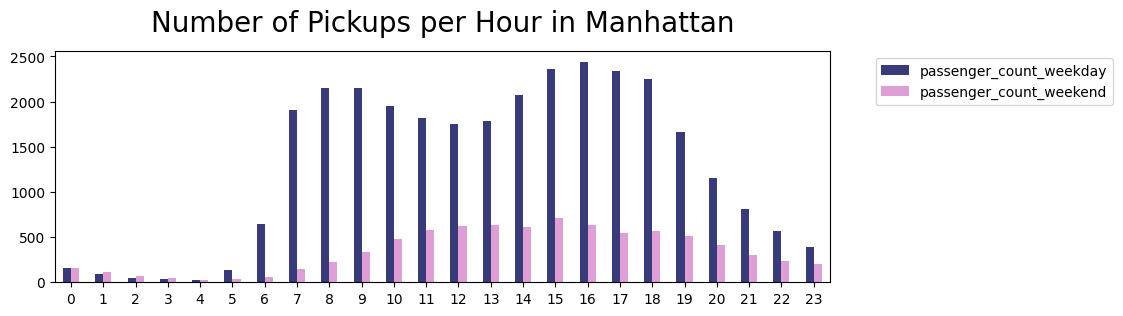

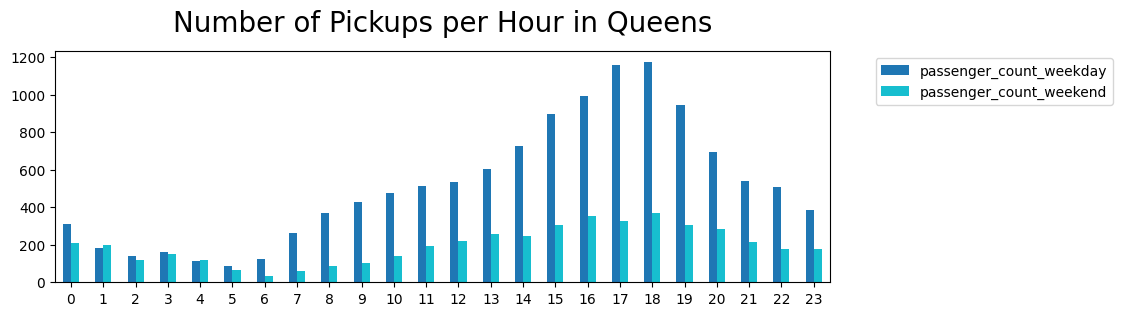

In [111]:
# Cek lokasi dropoff terbanyak untuk trip sesuai dengan lokasi pickupnya

# Create dataframe trip pickup
PH_Manhattan_weekday = df[(df.PU_Borough=="Manhattan") & (df.pickup_day_category=="Weekday")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Manhattan_weekend = df[(df.PU_Borough=="Manhattan") & (df.pickup_day_category=="Weekend")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Manhattan = pd.merge(PH_Manhattan_weekday, PH_Manhattan_weekend, on="pickup_hour").drop(columns="pickup_hour")
PH_Manhattan.rename(columns={"passenger_count_x":"passenger_count_weekday", "passenger_count_y":"passenger_count_weekend"}, inplace=True)

PH_Queens_weekday = df[(df.PU_Borough=="Queens") & (df.pickup_day_category=="Weekday")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Queens_weekend = df[(df.PU_Borough=="Queens") & (df.pickup_day_category=="Weekend")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Queens = pd.merge(PH_Queens_weekday, PH_Queens_weekend, on="pickup_hour").drop(columns="pickup_hour")
PH_Queens.rename(columns={"passenger_count_x":"passenger_count_weekday", "passenger_count_y":"passenger_count_weekend"}, inplace=True)

# plot Trip From Manhattan
ax = PH_Manhattan.plot(kind='bar', figsize=(10, 3), rot=0, colormap="tab20b")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Number of Pickups per Hour in Manhattan", fontsize=20, y=1.05)

# plot Trip From Queens
ax = PH_Queens.plot(kind='bar', figsize=(10, 3), rot=0, colormap="tab10")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Number of Pickups per Hour in Queens", fontsize=20, y=1.05)

plt.show();

Dari grafik diatas dapat disumpulkan:
1. Lokasi Borough di Manhattan
    * Pada kategori Weekday, peak hour terjadi pada jam berangkat ke kantor (pukul 8-9 pagi), dan pada setelah jam pulang kantor (pukul 15-16)
    * Pada kategori Weekend, cenderung stabil dari pukul 11 siang hingga pukul 18 sore
    * Jumlah pengguna taksi di Weekend jauh lebih sedikit dibanding Weekday
2. Lokasi Borough di Queens
    * Pada kategori Weekday, jumlah pengguna taksi selalu meningkat dari pukul 7 pagi hingga pukul 18 sore, dan mengalami penurunan permintaan pada pukul 19 hingga pukul 5 keesokan harinya
    * Pada kategori Weekend, polanya hampir sama dengan pola kategori Weekday, namun untuk frekuensi penggunaan taksi lebih rendah dari pada kategori Weekday
    * Jumlah pengguna taksi di Weekend lebih sedikit dibanding Weekday

##### **- Jenis pembayaran apa yang paling diminati?**

Jenis Pembayaran yang dapat digunakan pada green cabs ini adalah:
* 1=Credit card
* 2=Cash
* 3=No charge
* 4=Dispute
* 5=Unknown 

Kita akan menjawab jenis pembayaran mana yang paling diminati untuk trip dengan pickup di Borough Manhattan dan Queens

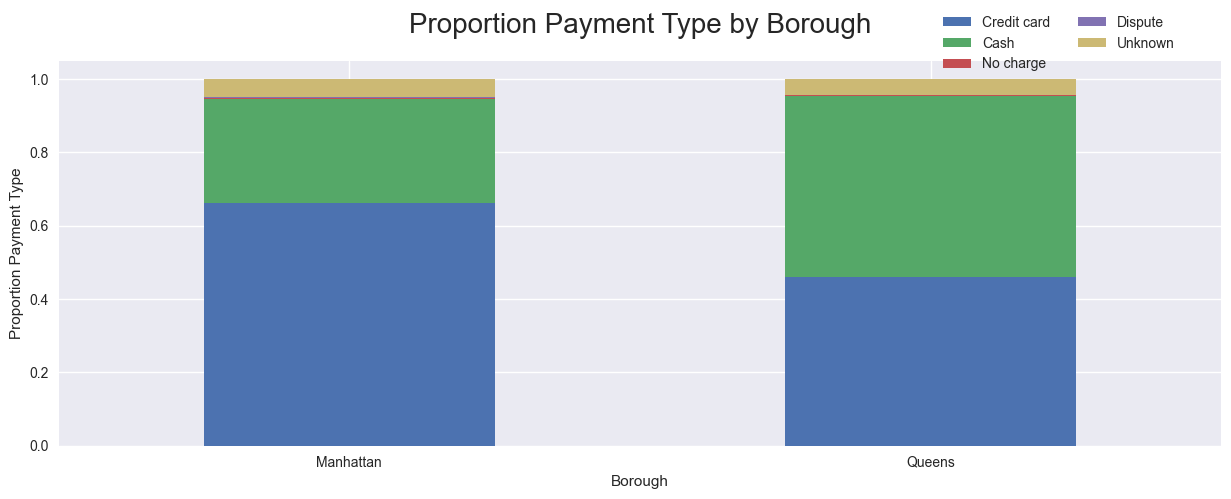

In [112]:
# Proportion Payment Type

payment_ct = pd.crosstab(df["payment_type"], df["PU_Borough"], margins=True)
payment_ct.drop(columns=["Bronx", "Staten Island", "Brooklyn"],inplace=True)
payment_ct = payment_ct[["Manhattan", "Queens"]]
payment_ct = ((payment_ct/payment_ct.iloc[-1])).T
payment_ct.drop(columns=["All"], inplace=True)
plt.style.use("seaborn")
plots = payment_ct.plot(kind="bar", stacked=True, figsize=(15, 5), )

plt.xticks(rotation=0)
plt.xlabel("Borough")
plt.ylabel("Proportion Payment Type")
plt.legend(["Credit card", "Cash", "No charge", "Dispute", "Unknown"], bbox_to_anchor =(0.75, 1.15), ncol = 2, loc="upper left")
plt.xticks(np.arange(len(payment_ct.index.tolist())),payment_ct.index.tolist())
plt.title("Proportion Payment Type by Borough", fontsize=20, y=1.05)

plt.show()

Dapat dilihat dari grafik diatas kita dapat menyimpulkan:
1. Pada lokasi pickup taksi di Manhattan, jenis pembayaran yang paling banyak dilakukan oleh penumpang ialah menggunakan Credit Card sebesar sekitar 70% dan Cash sebesar sekitar 30%
2. Pada lokasi Queens, jenis pembayaran relatif sama antara yang menggunakan Credit Card, maupun Cash, dengan ratio sekitar 50% 

Kita akan coba melakukan uji hipotesis menggunakan uji proporsi Z-Test single population pada masing-masing kota bagian (Manhattan dan Queens). Namun kita harus membagi data terlebih dahulu menjadi dua kategori variabel berdasarkan metode pembayaran menggunakan Credit Card dan Cash.

**Hypothesis**

- Ho : Proporsi metode pembayaran menggunakan Credit Card pada Manhattan = metode pembayaran menggunakan Cash pada Manhattan
- Ha : Proporsi metode pembayaran menggunakan Credit Card pada Manhattan > metode pembayaran menggunakan Cash pada Manhattan

In [113]:
# Uji hipotesis one sample Z-Test

# Proporsi trip distance < nilai median
jml_pmt = len(df[(df.PU_Borough.isin(["Manhattan", "Queens"])) & (df.payment_type==1)])
jml_all = len(df[(df.PU_Borough.isin(["Manhattan", "Queens"])) & (df.payment_type.isin([1,2]))])

# Uji Z-test one sample
from statsmodels.stats.proportion import proportions_ztest

stat, pvalue = proportions_ztest(
    count= jml_pmt,     # jumlah trip di Manhattan dengan payment type == Credit card
    nobs= jml_all,      # jumlah seluruh trip di Manhattan dengan payment type == Credit card dan Cash (sample)
    value= 0.5,          # proporsi teoritis (Ho)
    # alternative= "larger"
)

# conclusion
if pvalue > 0.05:
    print(f'''
    Pvalue = {pvalue/2}. Pvalue > 0.05. Gagal menolak Ho.
    Kita TIDAK MEMILIKI cukup bukti untuk mengatakan bahwa proporsi yang menggunakan jenis pembayaran Credit Card pada Manhattan
    sama dengan proporsi yang menggunakan jenis pembayaran Cash pada Manhattan.
    (Proporsinya TIDAK BERBEDA signifikan)
    ''')
else:
    print(f'''
    Pvalue = {pvalue/2:.10f}. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa proporsi yang menggunakan jenis pembayaran Credit Card pada Manhattan
    tidak sama dengan proporsi yang menggunakan jenis pembayaran Cash pada Manhattan.
    (Proporsinya BERBEDA signifikan)
    ''')    



    Pvalue = 0.0000000000. Pvalue <= 0.05. Berhasil menolak Ho.
    Kita MEMILIKI cukup bukti untuk mengatakan bahwa proporsi yang menggunakan jenis pembayaran Credit Card pada Manhattan
    tidak sama dengan proporsi yang menggunakan jenis pembayaran Cash pada Manhattan.
    (Proporsinya BERBEDA signifikan)
    


Dari uji statistik diatas, kita memiliki cukup bukti untuk pengguna yang melaksanakan trip dari kota bagian Manhattan lebih sering menggunakan Credit Card sebagai metode pembayaran dibanding menggunakan Cash atau metode pembayaran yang lainnya. Untuk pengguna taksi yang melaksanakan trip dari kota bagian Queens lebih sering menggunakan Credit Card dan Cash sebagai metode pembayaran.

### **3. Saran dan Rekomendasi**

Dari analisis yang telah dilakukan, kita dapat membuat kesimpulan sebagai berikut:
* 
* Pengguna taksi yang berasal (lokasi pickup) dari Manhattan memiliki proporsi yang tinggi untuk berakhir (lokasi dropoff) di Manhattan juga. Begitu pula untuk pengguna taksi dengan lokasi pickup di Queens memiliki tujuan akhir (dropoff) di Queens. Hal ini terjadi karena taksi lebih dipilih sebagai alat transportasi untuk perjalanan-perjalanan dengan jarak yang rendah (mempertimbangkan tarif permeter).
* Pada kota bagian Manhattan zona dropoff terbanyak berada di East Harlem South, East Harlem North, Upper East Side North, Central Harlemn dan Morningside Heights
* Pada kota bagian Queens zona dropoff terbanyak berada di Forest Hills, Jackson Heights, Astoria, Elmhurst, LaGuardia Airport
* Pada kota bagian Manhattan, permintaan taksi tertinggi terjadi pada Weekday di jam berangkat kantor (pukul 8-9 pagi) dan pada jam pulang kantor (pukul 15-16 sore), dan cenderung stabil pada Weekend (pukul 11 siang hingga 19 malam)
* Sedangkan pada kota bagian Queens, permintaan taksi selalu meningkat dari pukul 7 pagi hingga pukul 18 sore baik di Weekday maupun Weekend, namun frekuensi pada weekend lebih rendah dari pada Weekday
* Pengguna yang berasal dari kota bagian Manhattan memiliki proporsi yang lebih tinggi untuk menggunakan Credit Card sebagai metode pembayaran dibandingkan dengan metode pembayaran yang lain
* Proporsi metode pembayaran baik Credit Card maupun Cash untuk pengguna yang berasal dari kota bagian Queens memiliki proporsi yang sama

**Saran dan Rekomendasi**
* Untuk meningkatkan terget jumlah pengguna taksi hijau di **kota bagian Manhattan**, maka strategi bisnis yang dapat dilakukan adalah:
    * Buat promo marketing untuk trip dengan tujuan akhir East Harlem South, East Harlem North, Upper East Side North, dan Central Harlemn, karena wilayah tersebut berpengaruh signifikan terhadap jumlah penumpang
    * Perusahaan dapat memaksimalkan trip perjalan pada jam berangkat kantor dan pada saat pulang kantor, yakni pada pukul 08.00 - 09.00 pagi dan pukul 15.00 - 16.00 petang untuk weekday. Untuk weekend, perusahaan bisa menerapkan atau memberi promo akhir pekan pada sekitar pukul 11.00 - 19.00 malam.
    * Perusahaan juga dapat memberi promo cashback menggunakan metode pembayaran Credit Card, kerena metode pembayaran tersebut yang paling sering digunakan oleh user
<br>
* Untuk meningkatkan terget jumlah pengguna taksi hijau di **kota bagian Queens**, maka strategi bisnis yang dapat dilakukan adalah:
    * Buat promo marketing untuk trip dengan tujuan akhir Forest Hills, Jackson Heights, Astoria, Elmhurst, LaGuardia Airport, karena wilayah terssebut berpengaruh signifikan terhadap jumlah penumpang
    * Perusahaan dapat memaksimalkan trip perjalan yang selalu mengalami peningkatan dari jam 07.00 - 18.00 dengan puncak permintaan tertinggi pada jam 18.00. Hal yang sama baik untuk Weekday maupun weekend
    * Untuk kota bagian Queens metode pembayaran yang sering digunakan relatif sama baik menggunakan Credit Card maupun dengan Cash



In [114]:
# Simpan file CSV yang digunakan untuk analisis di python pandas

df.to_csv(r"D:\\Purwadhika JCDS\\Capstone Project\\Modul-2\data\\processed\data_analysis.csv", index = None, header=True)